In [2]:
import sys
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(color_codes=True)
import random

sys.path.insert(0, "../utils/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import gcf

In [3]:
random.seed(18)
print(random.random())

0.18126486333322134


In [4]:
# load the data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_init, test_init, val_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, drop_columns=False
)

train_df, test_df, val_df, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, drop_columns=True
)


#data_dir = "../0.data-download/data/"
model_df, effect_df = load_data(data_directory, adult_or_pediatric="all")

In [5]:
train_init["train_test_val"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_test_val"] = test_init.apply(lambda _: "test", axis=1)
val_init["train_test_val"] = val_init.apply(lambda _: "val", axis=1)

In [6]:
# load the latent dimension dataframe

latent_df = pd.read_parquet("../2.train-VAE/results/latent_df_multi.parquet")

print(latent_df.shape)

latent_df.head(5)

(958, 47)


,ModelID,0,1,2,3,4,5,6,7,8,...,36,37,38,39,40,41,42,43,44,45
0,ACH-000361,0.025931,2.387924,0.809982,-0.148803,0.373161,0.561800,0.217353,-0.319808,-0.457417,...,0.037120,-0.089137,-0.489976,0.114109,0.381043,0.857107,-0.158845,0.104769,0.388221,-0.089340
1,ACH-000976,0.204920,1.655128,1.226416,-0.119113,0.488210,0.835524,0.328486,-0.426965,-0.721762,...,0.031154,-0.057084,-0.774342,0.188903,0.600258,1.269340,-0.324252,0.190930,0.466871,-0.102514
2,ACH-000279,-0.099094,2.780113,0.499669,-0.164242,0.318842,0.397968,0.153849,-0.244441,-0.261233,...,0.030769,-0.126865,-0.302152,0.058069,0.216728,0.582330,-0.060259,0.061492,0.324820,-0.056467
3,ACH-000515,0.007886,1.505219,0.744236,-0.144784,0.380697,0.542743,0.223575,-0.307583,-0.413012,...,0.042636,-0.104760,-0.456300,0.107444,0.343572,0.809863,-0.167754,0.108999,0.352780,-0.062799
4,ACH-001523,-0.039205,3.544267,0.723933,-0.157942,0.359313,0.520307,0.193970,-0.309206,-0.390950,...,0.027381,-0.111357,-0.433464,0.097440,0.319197,0.804368,-0.126489,0.100475,0.377665,-0.051614


In [7]:
# create a data frame of both test and train gene effect data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init, val_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)

metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_test_val=train_and_test.train_test_val.astype(str),
)
metadata

,ModelID,AgeCategory,Sex,train_test_val
0,ACH-000361,Adult,Male,train
1,ACH-000976,Adult,Male,train
2,ACH-000279,Pediatric,Unknown,train
3,ACH-000515,Adult,Male,train
4,ACH-001523,Adult,Male,train
...,...,...,...,...
953,ACH-001402,Adult,Female,val
954,ACH-000834,Adult,Male,val
955,ACH-001498,Adult,Female,val
956,ACH-001795,Adult,Female,val


In [8]:
AgeCategory = metadata.pop("AgeCategory")
Sex = metadata.pop("Sex")
train_test = metadata.pop("train_test_val")

/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


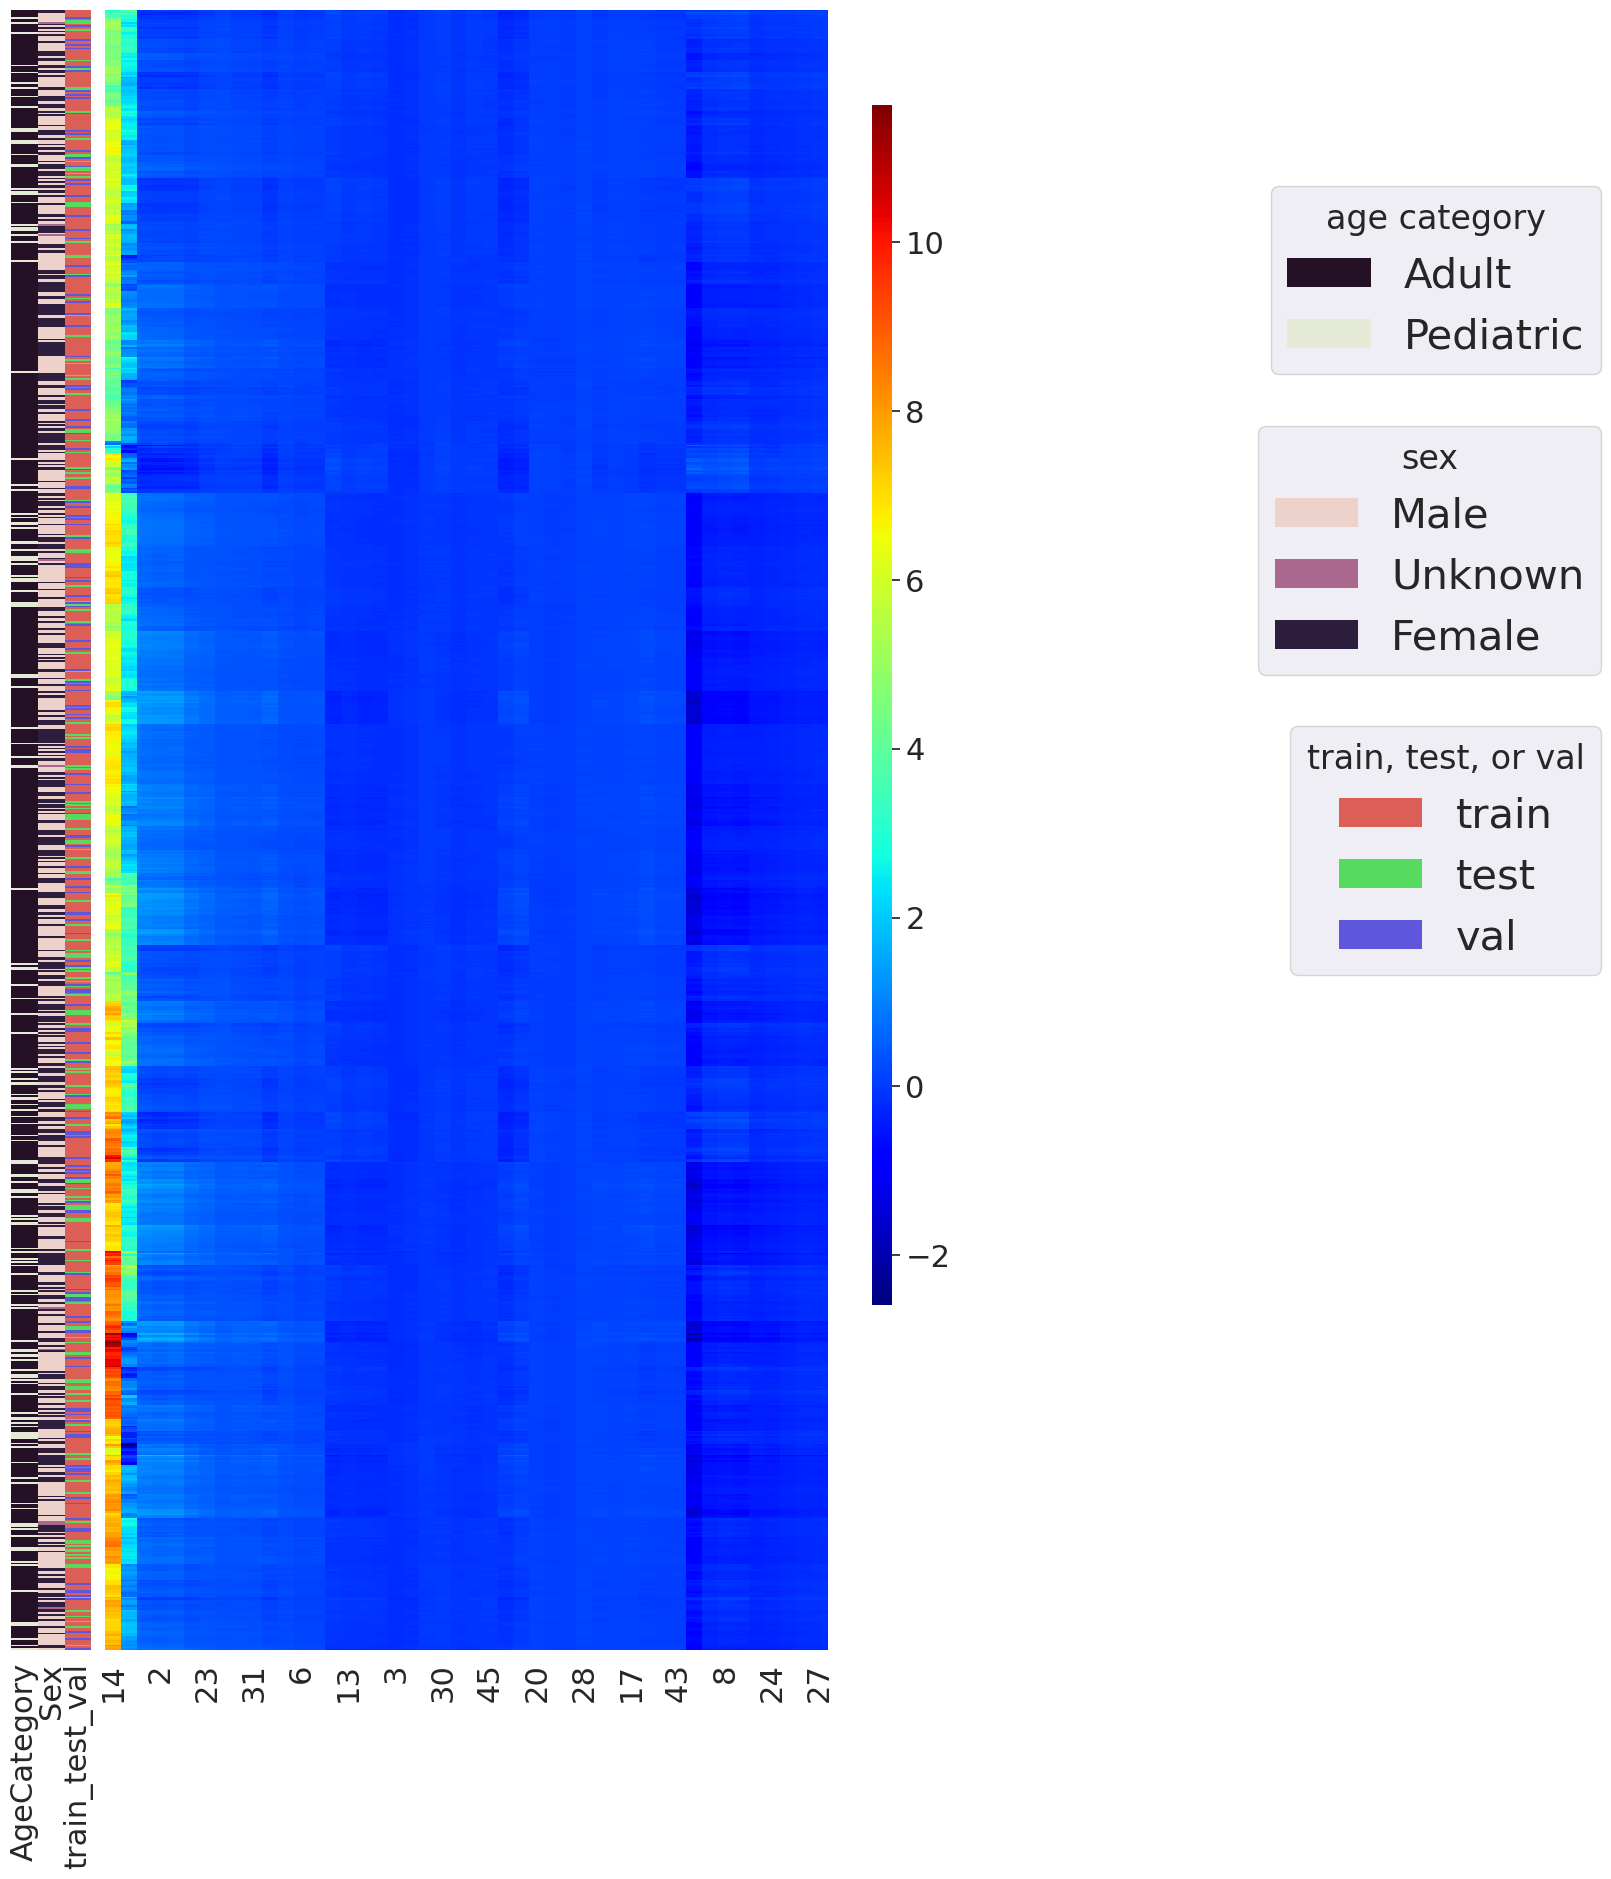

In [25]:
# display clustered heatmap of coefficients
lut_pal = sns.cubehelix_palette(
    AgeCategory.unique().size, light=0.9, dark=0.1, reverse=True, start=1, rot=-2
)
put_pal = sns.cubehelix_palette(Sex.unique().size)
mut_pal = sns.color_palette("hls", train_test.unique().size)

lut = dict(zip(AgeCategory.unique(), lut_pal))
put = dict(zip(Sex.unique(), put_pal))
mut = dict(zip(train_test.unique(), mut_pal))

row_colors1 = AgeCategory.map(lut)
row_colors2 = Sex.map(put)
row_colors3 = train_test.map(mut)

network_node_colors = pd.DataFrame(row_colors1).join(
    pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
)

sns.set(font_scale=2.0)
g = sns.clustermap(
    latent_df.iloc[:,1:],
    method="ward",
    figsize=(10, 20),
    row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "jet",
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)


xx = []
for label in AgeCategory.unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    xx.append(x)
# add the legend
legend3 = plt.legend(
    xx,
    AgeCategory.unique(),
    loc="upper right",
    title="age category",
    ncol=1,
    bbox_to_anchor=(1.75, 0.87),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)


yy = []
for label in Sex.unique():
    y = g.ax_row_dendrogram.bar(0, 0, color=put[label], label=label, linewidth=0)
    yy.append(y)
# add the second legend
legend4 = plt.legend(
    yy,
    Sex.unique(),
    loc="upper right",
    title="sex",
    ncol=1,
    bbox_to_anchor=(1.75, 0.75),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend3)


zz = []
for label in train_test.unique():
    z = g.ax_row_dendrogram.bar(0, 0, color=mut[label], label=label, linewidth=0)
    zz.append(z)
# add the third legend
legend5 = plt.legend(
    zz,
    train_test.unique(),
    loc="upper right",
    title="train, test, or val",
    ncol=1,
    bbox_to_anchor=(1.75, 0.6),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend4)


# save the figure
heat_save_path = pathlib.Path("../1.data-exploration/figures/heatmap.png")
plt.savefig(heat_save_path, bbox_inches="tight", dpi=600)

In [10]:
# load the weights dataframe

gene_weights_df = pd.read_parquet("../2.train-VAE/results/weight_matrix_encoder.parquet")

gene_weights_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.109315,-0.038482,0.014480,-0.149140,0.074842,-0.061868,-0.161137,0.058640,0.177218,-0.020343,-0.209651,-0.125647,0.029376,-0.010063
1,0.031690,0.092073,0.043491,-0.033877,0.102488,0.059717,-0.045368,0.018479,0.117420,0.092783,-0.029958,0.016379,-0.049194,0.076713
2,0.086128,0.010753,-0.012336,0.024410,-0.076728,-0.101889,-0.052603,-0.022650,-0.118783,0.049498,-0.077891,-0.011055,-0.049026,0.101191
3,-0.110724,-0.150230,0.099385,0.201614,0.147577,-0.156639,-0.274500,0.094756,0.010016,0.251778,-0.173598,-0.238813,-0.105723,0.054507
4,0.166172,-0.324120,-0.160321,-0.085624,0.014885,-0.069466,-0.059795,-0.022560,0.030648,0.183350,-0.082616,-0.243798,0.057961,0.162231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713,0.076213,0.018613,-0.029018,0.063529,0.071316,-0.090523,-0.058557,-0.040333,-0.014207,0.125129,0.151859,0.013636,-0.125089,0.023458
2714,0.023654,-0.059157,-0.083616,-0.018223,0.081886,-0.100828,-0.199909,0.050880,0.038602,-0.060780,-0.285051,-0.208035,0.087263,0.075485
2715,-0.176392,0.054563,0.196796,-0.014067,0.086251,-0.048394,-0.145285,0.154330,0.173067,0.019783,-0.240784,-0.080660,0.085943,-0.025766
2716,-0.065832,-0.011554,0.134001,0.038549,0.056097,0.052169,-0.037407,0.071350,0.009601,0.045348,0.056310,-0.013521,0.123449,0.035393


/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


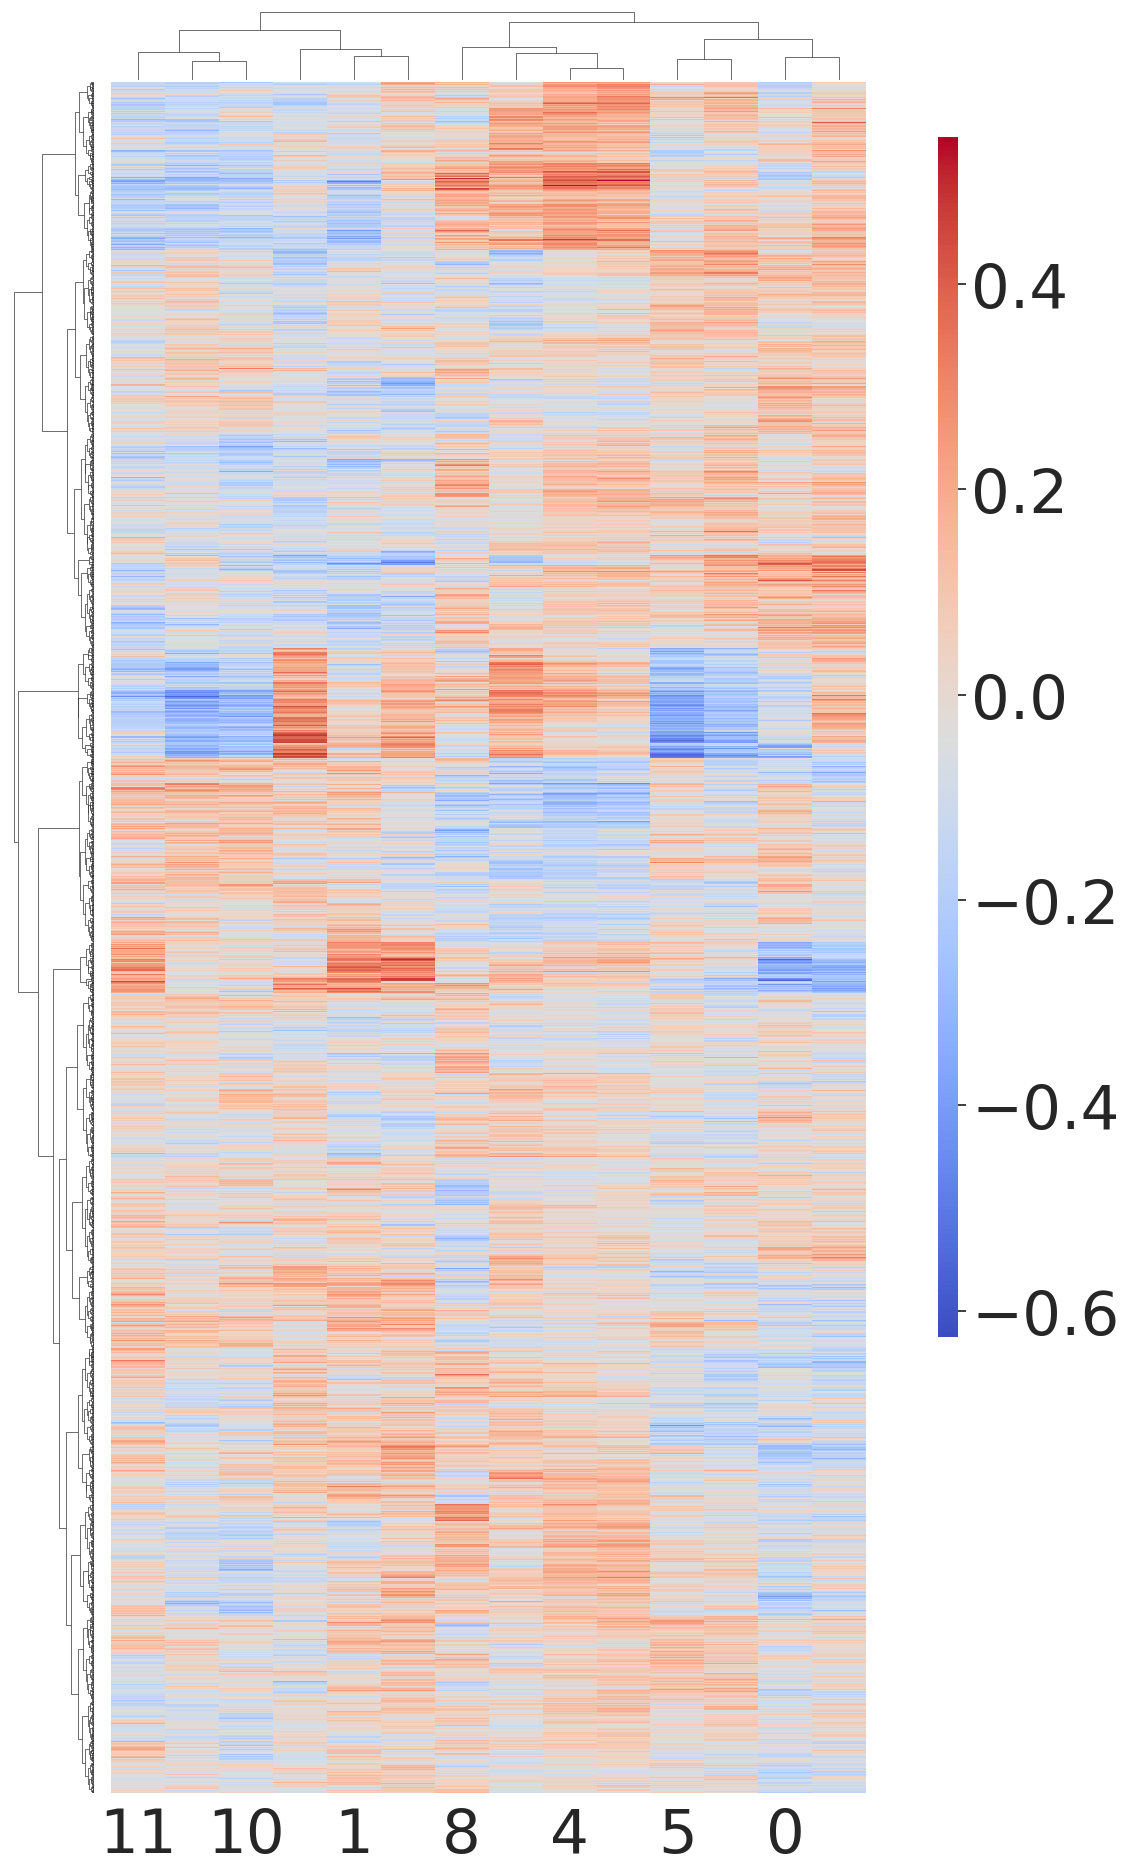

In [11]:
sns.clustermap(
    gene_weights_df,
    method="ward",
    figsize=(10, 20),
    #network_node_colors = pd.DataFrame(row_colors1).join(pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
    #row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
